**策略描述**

基本思想是始终持有过去一段时间涨幅大（动量强）的资产，在多种资产间进行轮动。构建步骤如下：

1. 每日计算每个ETF过去21个交易日（含计算当日）的涨跌幅作为动量。

2. 比较动量，选择动量最大的ETF作为投资标的，以当日收盘价买入对应的ETF基金。

3. 持有所购买的ETF基金，直到下一个调仓日。

4. 每个调仓日重复以上步骤，根据涨幅更大的指数进行轮动投资。

[策略来源链接](https://mp.weixin.qq.com/s/2pl_Vv64yoI5GhPyN1t4Aw)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import math
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from copy import deepcopy

实例选择的资产：

黄金(ETF基金:518880)：  
黄金是一种避险资产，通常在经济不稳定或通货膨胀高企时表现较好。  
它的价格与股票和其他金融资产的表现通常存在负相关关系，因此可以用来对冲股票市场风险。  
黄金还被认为是一种通胀对冲资产，因为它的价格通常会在通货膨胀上升时上涨。

纳指(ETF基金:513100)：  
纳斯达克指数代表了美国科技股市场的表现。  
科技股通常具有高增长性和高估值，是投资组合中增长部分的重要组成部分。  
与其他股票市场（如沪深300）相比，纳斯达克指数的波动性通常更高。  
因此，它可以通过与其他股票市场的组合来实现资产组合的多样化。

创业板(ETF基金:159915)：  
创业板指数代表了中国创新型企业的表现。  
创业板股票通常具有高估值和高风险，但也具有高增长潜力。  
与沪深300等传统股票市场相比，创业板通常更具有成长性和波动性。  
因此，它可以用来增加投资组合的成长性和风险。

红利(ETF基金:510880)：  
红利以A 股中高现金股息率，分红稳定、具有一定规模及流动性的 50 只股票组成，  
采用股息率作为权重分配依据，以反映沪市 A 股市场高红利股票的整体表现。  
红利与高成长的创业板分属不同赛道，A股内拥挤度相对较低。

黄金、纳指、创业板和红利代表了不同类型、风格和市场的资产，它们之间具有一定的互补性。  
通过将这些资产组合在一起，可以实现投资组合的多样化和风险分散。在选择资产时，需要考虑  
到资产的特性和风险收益特征，以及投资者的风险偏好和目标。

In [2]:
class EtfPool():
    """
    ETF池类，用于获取ETF池的历史数据，计算各支ETF的涨跌幅和均线数据，选取信号，绘制策略累计收益率曲线，
    以及进行止损止盈策略的参数分析和绘制热力图

    Attributes:
    tickers: ETF池的代码列表
    data: ETF池的历史数据

    __init__(): 初始化函数
    get_data(): 利用akshare获取ETF池的各支ETF的历史数据，重命名列名，合并各支ETF的价格以及均线数据到data属性
    plot_return(): 绘制对应ETF池的策略累计收益率曲线
    stop_loss(): 止损函数
    stop_win(): 止盈函数
    plot_stop_loss_param_analysis(): 绘制不同参数组合下的总收益率热力图
    plot_stop_win_param_analysis(): 绘制不同参数组合下的总收益率热力图
    get_result(): 计算不同参数组合下的总收益率
    plot_result(): 绘制对应ETF池的策略累计收益率曲线
    """
    def __init__(self, tickers) -> None:
        """
        初始化函数

        Args:
        tickers: ETF池的代码列表

        Returns:
        None
        """
        super().__init__()
        self.tickers = tickers
        self.data = None

    def get_data(self, start_date: str = "19700101",end_date: str = "20500101") -> None:
        """
        利用akshare获取ETF池的各支ETF的历史数据，重命名列名，合并各支ETF的价格以及均线数据到data属性

        Args:
        start_date: 开始日期
        end_date: 结束日期

        Returns:
        None
        """

        etf_data = {}
        etf_symbols = self.tickers
        window = 21

        # 获取 ETF 历史数据
        for symbol in etf_symbols:
            etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", start_date= start_date, end_date= end_date, adjust='hfq')[['日期', '收盘']] \
                .rename(columns={'日期': 'date', '收盘': symbol}).set_index('date')
            etf_data[symbol] = etf_df

        # 合并数据并对齐
        data = pd.concat(list(etf_data.values()), axis=1).dropna()
        data.index = pd.to_datetime(data.index)

        # 计算每日涨跌幅和滚动收益率
        for symbol in etf_symbols:
            column_name = f"{symbol}"
            data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1] / x[0] - 1)
            data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1] / x[0] - 1)
            data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

        # 去掉缺失值
        data = data.dropna()

        # 依照动量策略选取信号
        data['signal'] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split('_').str[0]
        data['signal'] = data['signal'].shift(1)
        data = data.dropna()
        data['signal_day_return'] = data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)
        data["signal_return"] = (np.cumprod(data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)
        data = data.dropna()

        # 保存基准策略收益率
        data['base_strategy_day_return'] = data["signal_day_return"].apply(deepcopy)
        data['base_strategy_return'] = data["signal_return"].apply(deepcopy)

        self.data = data
    
    def plot_return(self):
        """
        绘制对应ETF池的策略累计收益率曲线

        Args:
        None

        Returns:
        None
        """
        data = self.data
        etf_symbols = self.tickers
        print(f"累计收益率：{data.iloc[-1]['signal_return']}")
        # 绘制曲线图
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_xlabel('Time')
        ax.set_ylabel('Return')

        signal_return_v1=data["signal_return"].values
        ax.plot(data["signal_return"].index, signal_return_v1)
        ax.legend(etf_symbols + ["signal_return"])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

        # 定义色块颜色映射
        color_map = {'518880': 'orange', '513100': 'blue', '159915': 'green', '510880': 'red'}

        # 添加色块
        prev_signal = None
        for i, (index, row) in enumerate(data.iterrows()):
            current_signal = row['signal']
            if i == 0:
                prev_signal = current_signal
                continue
            
            color = color_map[current_signal]
            ax.axvspan(data.index[i - 1], index, facecolor=color, alpha=0.3)
            
            # 检查当前信号与前一个信号是否不同
            if current_signal != prev_signal: 
                prev_signal = current_signal

        # 创建色块标签
        legend_handles = [plt.Rectangle((0,0),1,1, color=color_map[sig]) for sig in color_map]
        legend_labels = list(color_map.keys())

        # 显示图例
        ax.legend(legend_handles, legend_labels)

        # 显示图形
        plt.show()

    def result(self):
        # 计算策略表现指标
        result = {}
        data = self.data
        etf_symbols = self.tickers

        for symbol in etf_symbols + ["signal",]:
            column_name = f"{symbol}_return"
            result[column_name] = []
            for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
                r = getattr(qs.stats, stat)(data[column_name])
                result[column_name].append(r)
        result["base_strategy_return"] = []
        for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
            result["base_strategy_return"].append(getattr(qs.stats, stat)(data["base_strategy_return"]))

        result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])

        return result
    
    def stop_loss(self, input_list, window_size, loss_threshold, stop_period):
            """
            止损函数
            
            Args:
            input_list: 输入列表
            window_size: 观察窗口
            loss_threshold: 回撤阈值
            stop_period: 清仓天数

            Returns:
            input_list: 处理后的列表   
            """
            for i in range(len(input_list)):
                if i >= window_size:
                    loss_local = math.prod(input_list[i+1-window_size:i+1]+1)
                    if loss_local-1 < loss_threshold:
                        input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
            return input_list
        
    def stop_win(self, input_list, window_size, win_threshold, stop_period):
            """
            止盈函数

            Args:
            input_list: 输入列表
            window_size: 观察窗口
            win_threshold: 上涨阈值
            stop_period: 清仓天数

            Returns:
            input_list: 处理后的列表
            """
            for i in range(len(input_list)):
                if i >= window_size:
                    win_local = math.prod(input_list[i+1-window_size:i+1]+1)
                    if win_local-1 > win_threshold:
                        input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
            return input_list
    
    def plot_stop_loss_param_analysis(self, stop_periods, window_sizes, thresholds):
        """
        绘制不同参数组合下的总收益率热力图

        Args:
        stop_periods: 清仓天数
        window_sizes: 观察窗口
        thresholds: 回撤阈值

        Returns:
        None
        """
    
        def param_total_return(window_sizes, thresholds, stop_periods):
            """
            计算不同参数组合下的总收益率

            Args:
            window_sizes: 观察窗口
            thresholds: 回撤阈值
            stop_periods: 清仓天数

            Returns:
            matrix_data: 三维矩阵，每一维对应一个参数组合下的总收益率
            """
            total_returns = []
            data = self.data

            # 计算不同参数组合下的总收益率
            for stop_period in stop_periods:
                for window_size in window_sizes:
                    for loss_threshold in thresholds:
                        signal_day_return = data['base_strategy_day_return'].apply(deepcopy)
                        data['stop_loss_day_return'] = self.stop_loss(signal_day_return, window_size, loss_threshold, stop_period)
                        data["signal_return"] = (np.cumprod(data['stop_loss_day_return'] + 1) * 100)
                        total_returns.append(data["signal_return"][-1])

            matrix_data = np.array(total_returns).reshape(len(stop_periods), len(window_sizes), len(thresholds))
            return matrix_data

        # 绘制热力图主函数
        start_time = time.time()
        matrix_data = param_total_return(window_sizes, thresholds, stop_periods).astype(int)
        fig, axes = plt.subplots(3, 3, figsize=(15,15), dpi=500)

        for i, data in enumerate(matrix_data):
            row = i % 3
            col = i // 3
            ax = axes[row, col]
            sns.heatmap(data.T, ax=ax, xticklabels=window_sizes, yticklabels=thresholds, cmap="coolwarm", \
                        annot=False,  linewidths=0.5, linecolor='black')
            ax.set_xlabel('观察窗口')
            ax.set_ylabel('回撤阈值')
            ax.set_title(f"清仓天数：m = {stop_periods[i]}") 
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.show()
        end_time = time.time()
        execution_time = end_time - start_time
        print("代码执行时间：", int(execution_time), "秒")
    
    def plot_stop_win_param_analysis(self, stop_loss_param, stop_periods, window_sizes, thresholds):
        """
        绘制不同参数组合下的总收益率热力图

        Args:
        stop_loss_param: 止损参数
        stop_periods: 清仓天数
        window_sizes: 观察窗口
        thresholds: 上涨阈值

        Returns:
        None
        """
    
        def base_on_stop_loss_param_total_return(stop_loss_param, window_sizes, thresholds, stop_periods):
            """
            计算不同参数组合下的总收益率

            Args:
            stop_loss_param: 止损参数
            window_sizes: 观察窗口
            thresholds: 上涨阈值
            stop_periods: 清仓天数

            Returns:
            matrix_data: 三维矩阵，每一维对应一个参数组合下的总收益率
            """
            total_returns = []
            data = self.data
            stop_loss_stop_period, stop_loss_window_size, stop_loss_threshold = stop_loss_param

            # 计算不同参数组合下的总收益率
            for stop_period in stop_periods:
                for window_size in window_sizes:
                    for win_threshold in thresholds:
                        signal_day_return = data['base_strategy_day_return'].apply(deepcopy)
                        signal_day_return = self.stop_loss(signal_day_return, stop_loss_window_size, stop_loss_threshold, stop_loss_stop_period)
                        data['stop_win_day_return'] = self.stop_win(signal_day_return, window_size, win_threshold, stop_period)
                        data["signal_return"] = (np.cumprod(data['stop_win_day_return'] + 1) * 100)
                        total_returns.append(data["signal_return"][-1])

            matrix_data = np.array(total_returns).reshape(len(stop_periods), len(window_sizes), len(thresholds))
            return matrix_data

        # 绘制热力图主函数
        start_time = time.time()
        matrix_data = base_on_stop_loss_param_total_return(stop_loss_param, window_sizes, thresholds, stop_periods).astype(int)
        fig, axes = plt.subplots(3, 3, figsize=(15,15), dpi=500)

        for i, data in enumerate(matrix_data):
            row = i % 3
            col = i // 3
            ax = axes[row, col]
            sns.heatmap(data.T, ax=ax, xticklabels=window_sizes, yticklabels=thresholds, cmap="coolwarm", \
                        annot=False,  linewidths=0.5, linecolor='black')
            ax.set_xlabel('观察窗口')
            ax.set_ylabel('上涨阈值')
            ax.set_title(f"清仓天数：m = {stop_periods[i]}") 
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.show()
        end_time = time.time()
        execution_time = end_time - start_time
        print("代码执行时间：", int(execution_time), "秒")
        
    def get_result(self, stop_loss_param, stop_win_param):
        """
        计算不同参数组合下的总收益率

        Args:
        stop_loss_param: 止损参数
        stop_win_param: 止盈参数

        Returns:
        None
        """
        stop_loss_stop_period, stop_loss_window_size, stop_loss_threshold = stop_loss_param
        stop_win_stop_period, stop_win_window_size, stop_win_threshold = stop_win_param
        data = self.data
        signal_day_return = data['signal_day_return'].copy()
        data['stop_loss_day_return'] = self.stop_loss(signal_day_return, stop_loss_window_size, stop_loss_threshold, stop_loss_stop_period)
        data['stop_win_day_return'] = self.stop_win(data['stop_loss_day_return'], stop_win_window_size, stop_win_threshold, stop_win_stop_period)
        data["signal_return"] = (np.cumprod(data['stop_win_day_return'] + 1) * 100)
        self.data = data
        print(f"累计收益率：{data.iloc[-1]['signal_return']}")
        
        return None
    
    def plot_result(self):
        """
        绘制对应ETF池的策略累计收益率曲线

        Args:
        data: 数据

        Returns:
        None
        """
        data = self.data

        # 绘制曲线图
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_xlabel('Time')
        ax.set_ylabel('Return')

        ax.plot(data["base_strategy_return"].index, data["base_strategy_return"].values)
        ax.plot(data["signal_return"].index, data["signal_return"].values)
        ax.legend(["former_return", "signal_return"])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

        # 标记连续为0的段
        start = None
        length = 0  # 用于计数连续0的长度
        for i, value in enumerate(data['stop_win_day_return']):
            if value == 0:
                if start is None:
                    start = i  # 记录连续0开始的位置
                length += 1  # 增加连续0的计数
            else:
                if start is not None and length >= 5:
                    ax.axvspan(data.index[start], data.index[i-1], color='red', alpha=0.3)  # 使用红色区块标记连续至少两次为0的区间
                start = None  # 重置开始位置
                length = 0  # 重置长度计数
        if start is not None and length >= 2:  # 确保最后一个连续为0的段也被标记
            ax.axvspan(data.index[start], data.index[len(data)-1], color='red', alpha=0.3)

        plt.title("add stop_loss_and_win compare to base strategy")
        # 显示图形
        plt.show()

累计收益率：1683.8862882765986


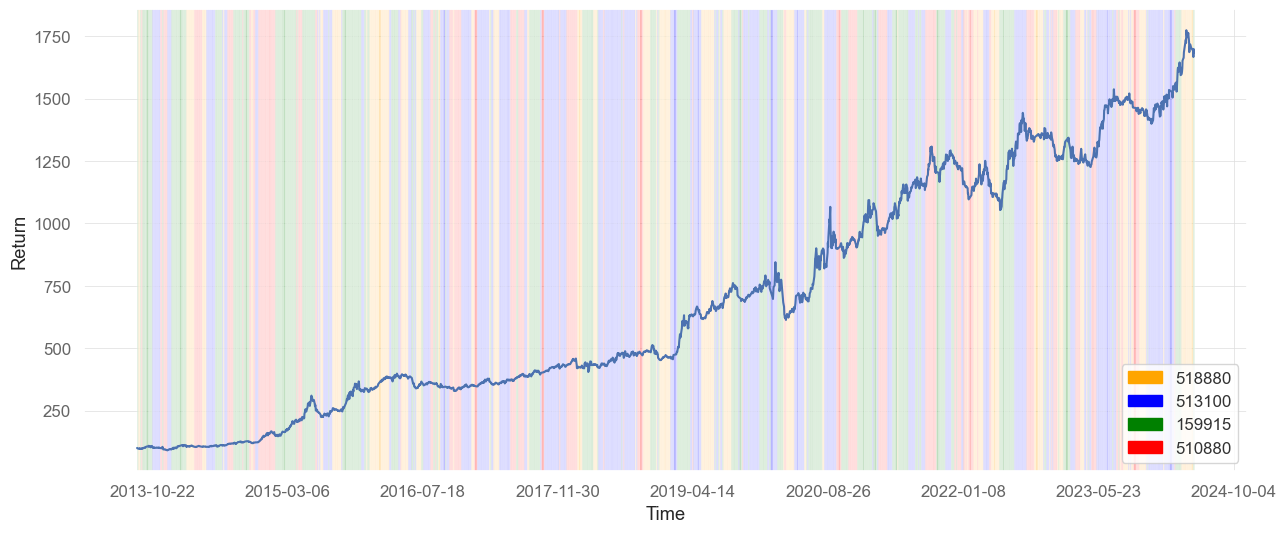

In [3]:
pool_1 = EtfPool(['518880', '513100', '159915', '510880'])
pool_1.get_data()
pool_1.plot_return()


原策略未考虑止盈止损，我们改进策略：

**风险管理**

止损：每日计算过去n日收益率（含计算当日），若过去n日累计收益率低于s，清仓止损，并m天不开仓。

对参数 ：观察窗口天数：n, 回撤阈值：s, 清仓天数：m ，进行敏感度分析

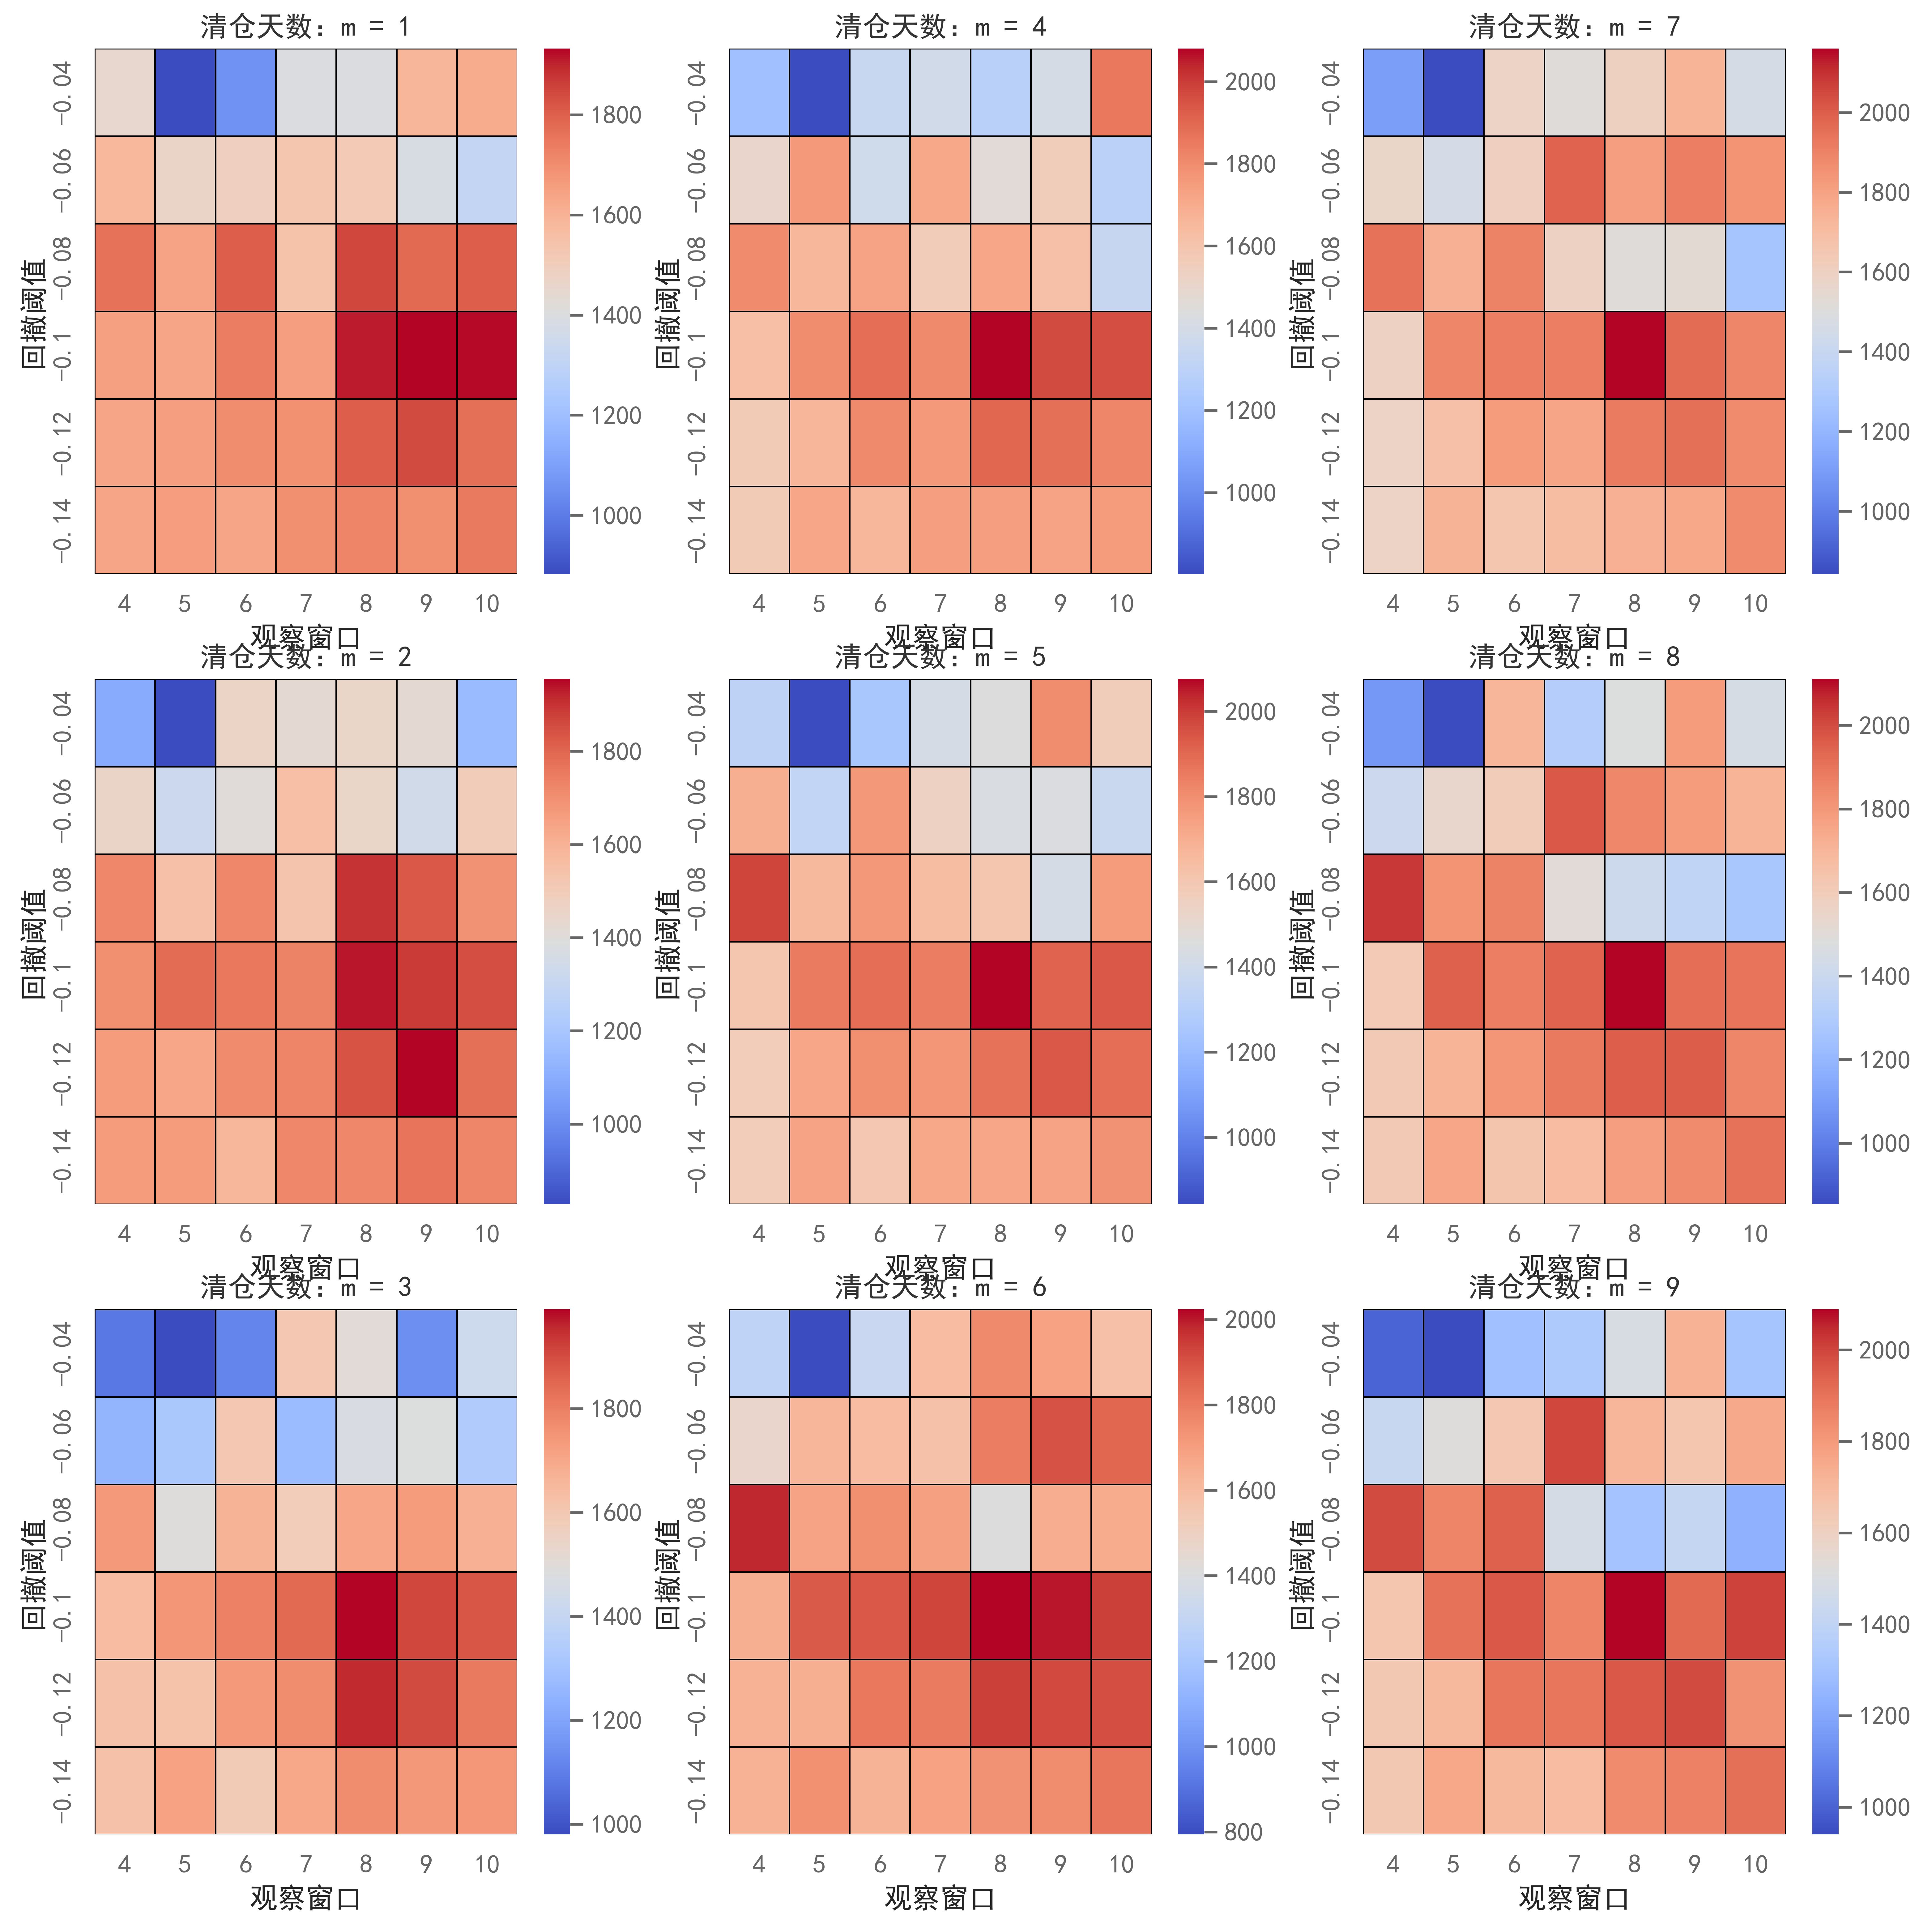

代码执行时间： 205 秒


In [4]:

#画出m = 1-9 时，不同回撤阈值和观察窗口的止损后收益率热力图
# 观察窗口：n 
window_sizes = [4, 5, 6, 7, 8, 9, 10]
# 回撤阈值：s 
thresholds = [-0.04, -0.06, -0.08, -0.1, -0.12, -0.14]
# 清仓天数：m 
stop_periods = list(range(1,10))
pool_1.plot_stop_loss_param_analysis(stop_periods, window_sizes, thresholds)

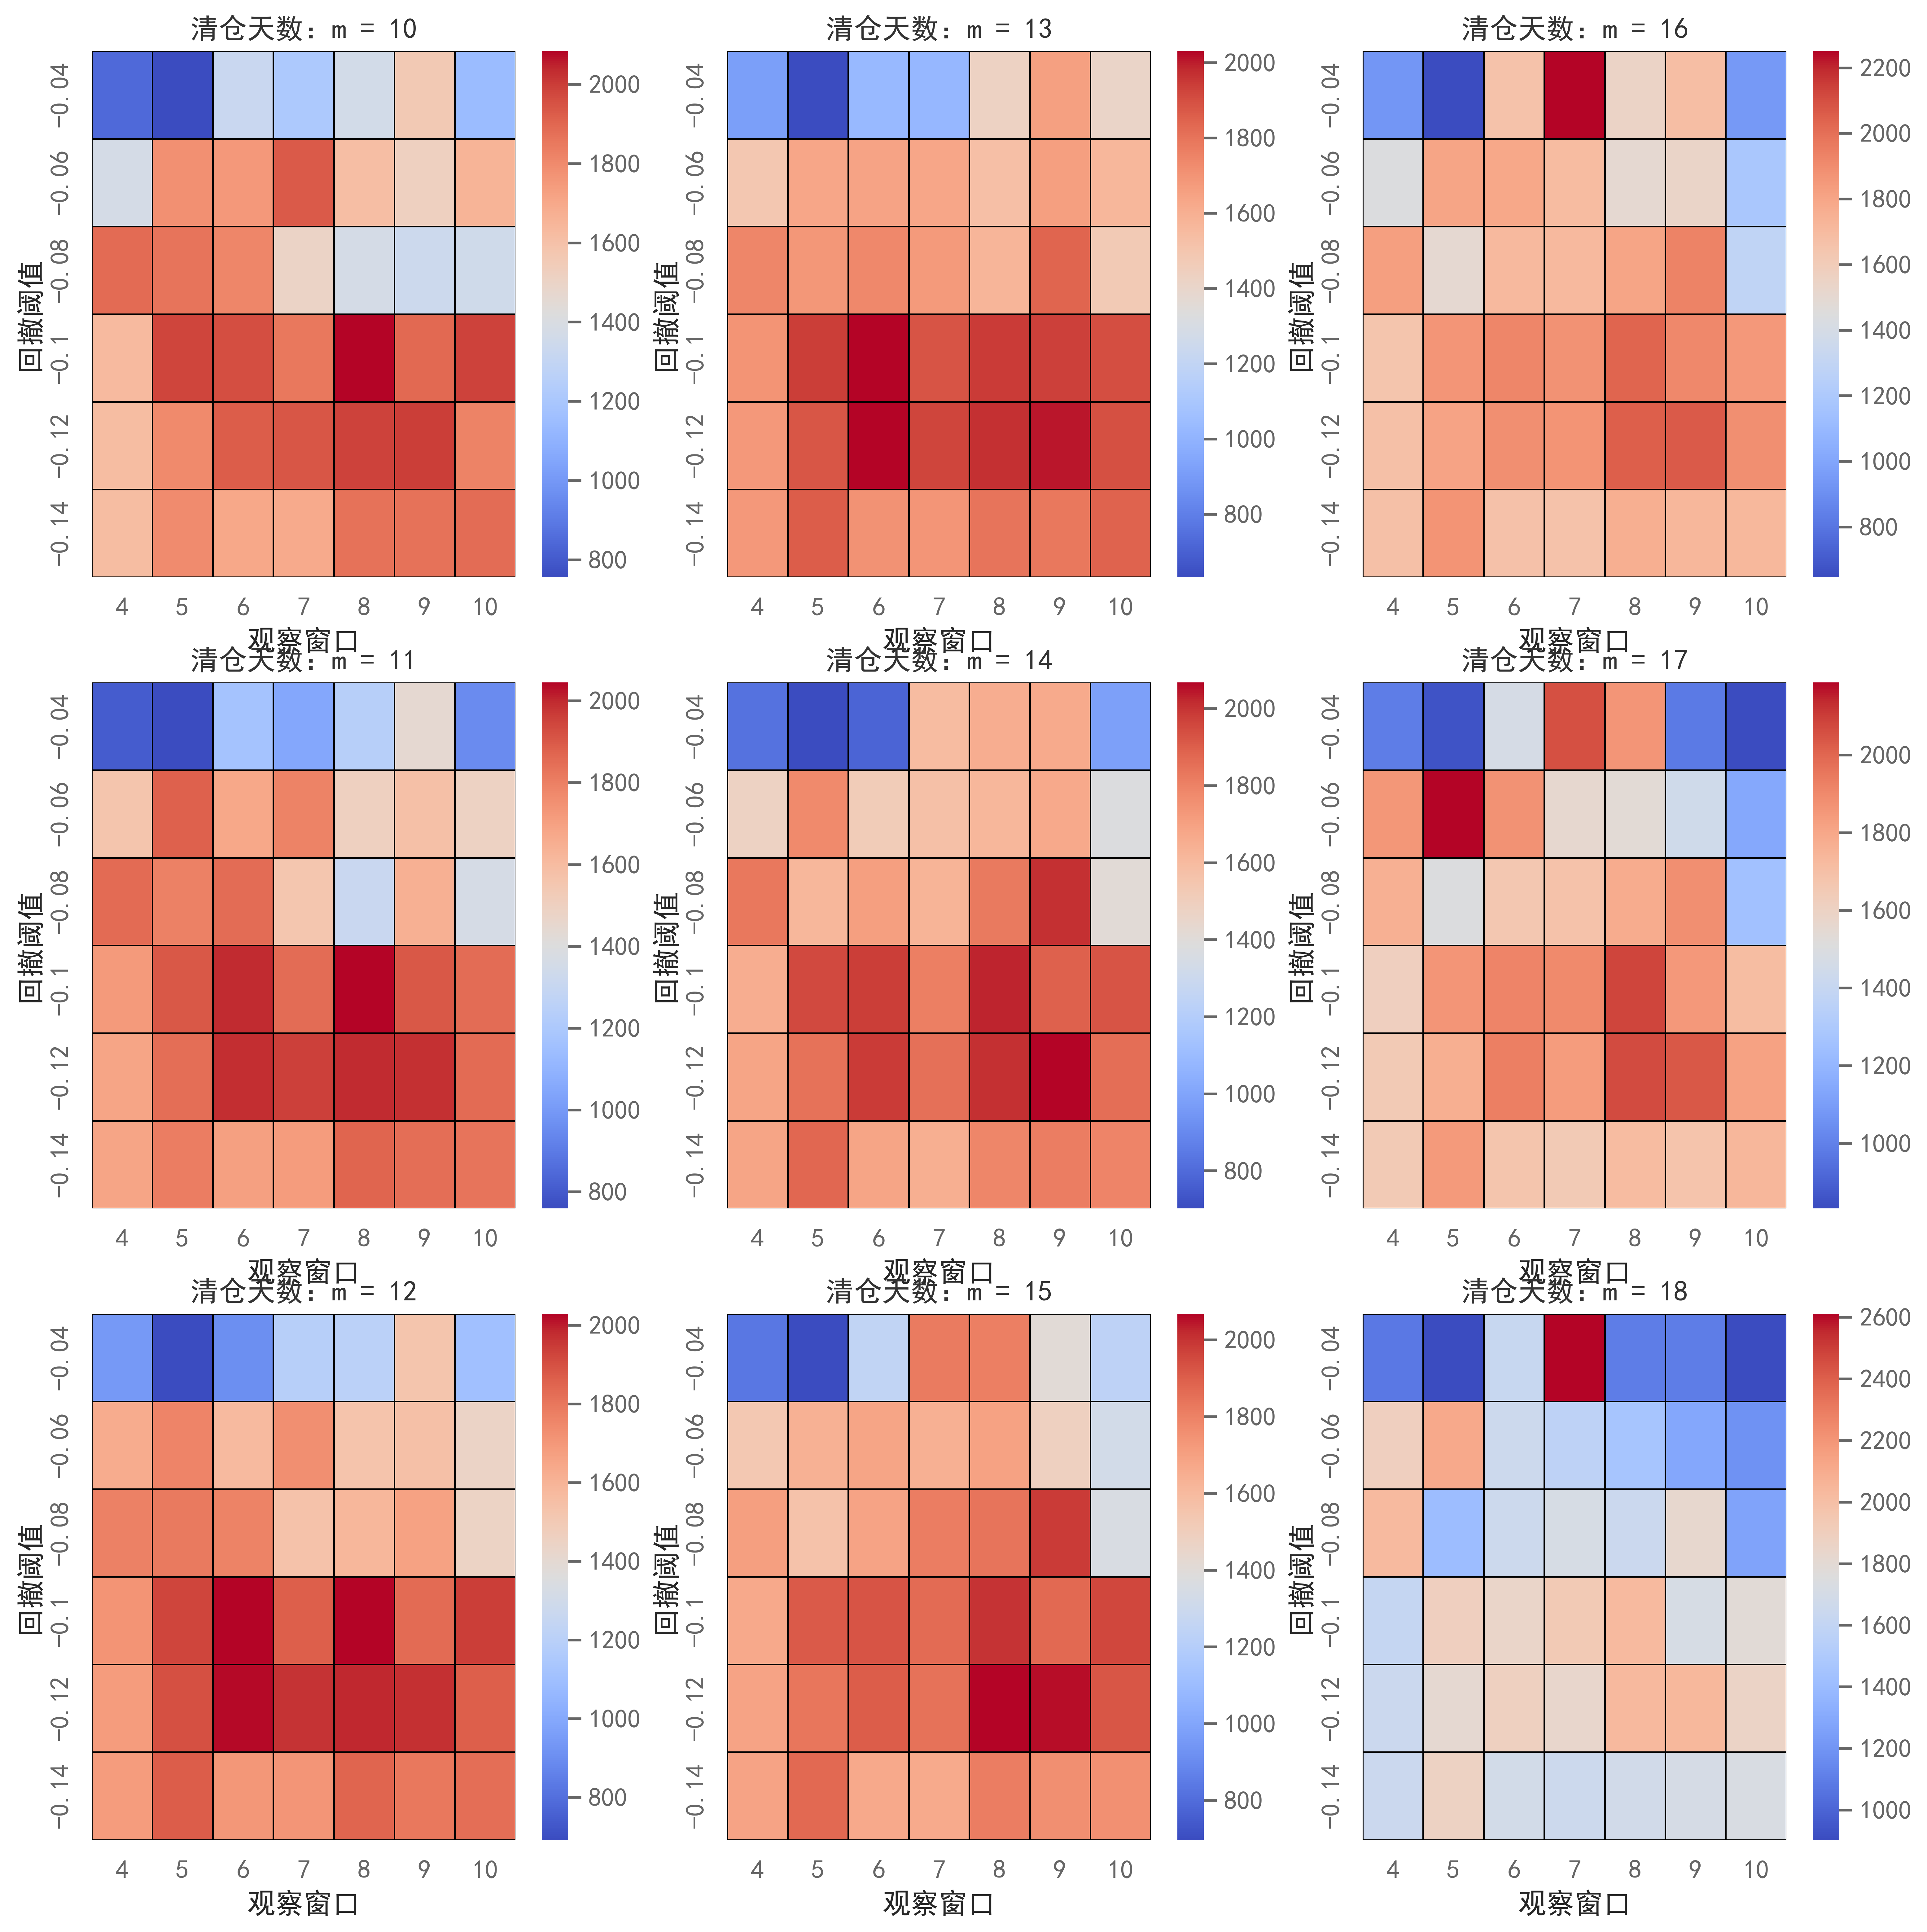

代码执行时间： 200 秒


In [5]:
#画出m = 10-18 时，不同回撤阈值和观察窗口的止损后收益率热力图
stop_periods = list(range(10,19))
pool_1.plot_stop_loss_param_analysis(stop_periods, window_sizes, thresholds)

先确认止损的参数，在热力图上看出“观察窗口天数：n = 8，回撤阈值：s = -0.12，清仓天数：m = 15” ，附近收益率较为接近，且该点处收益率较高，故确定止损参数：n, s, m = (8, -0.12, 15) 

再对止损后的策略进行**止盈参数敏感度分析**

止盈：每日计算过去n日收益率（含计算当日），若过去n日累计收益率低于s，清仓止损，并m天不开仓。

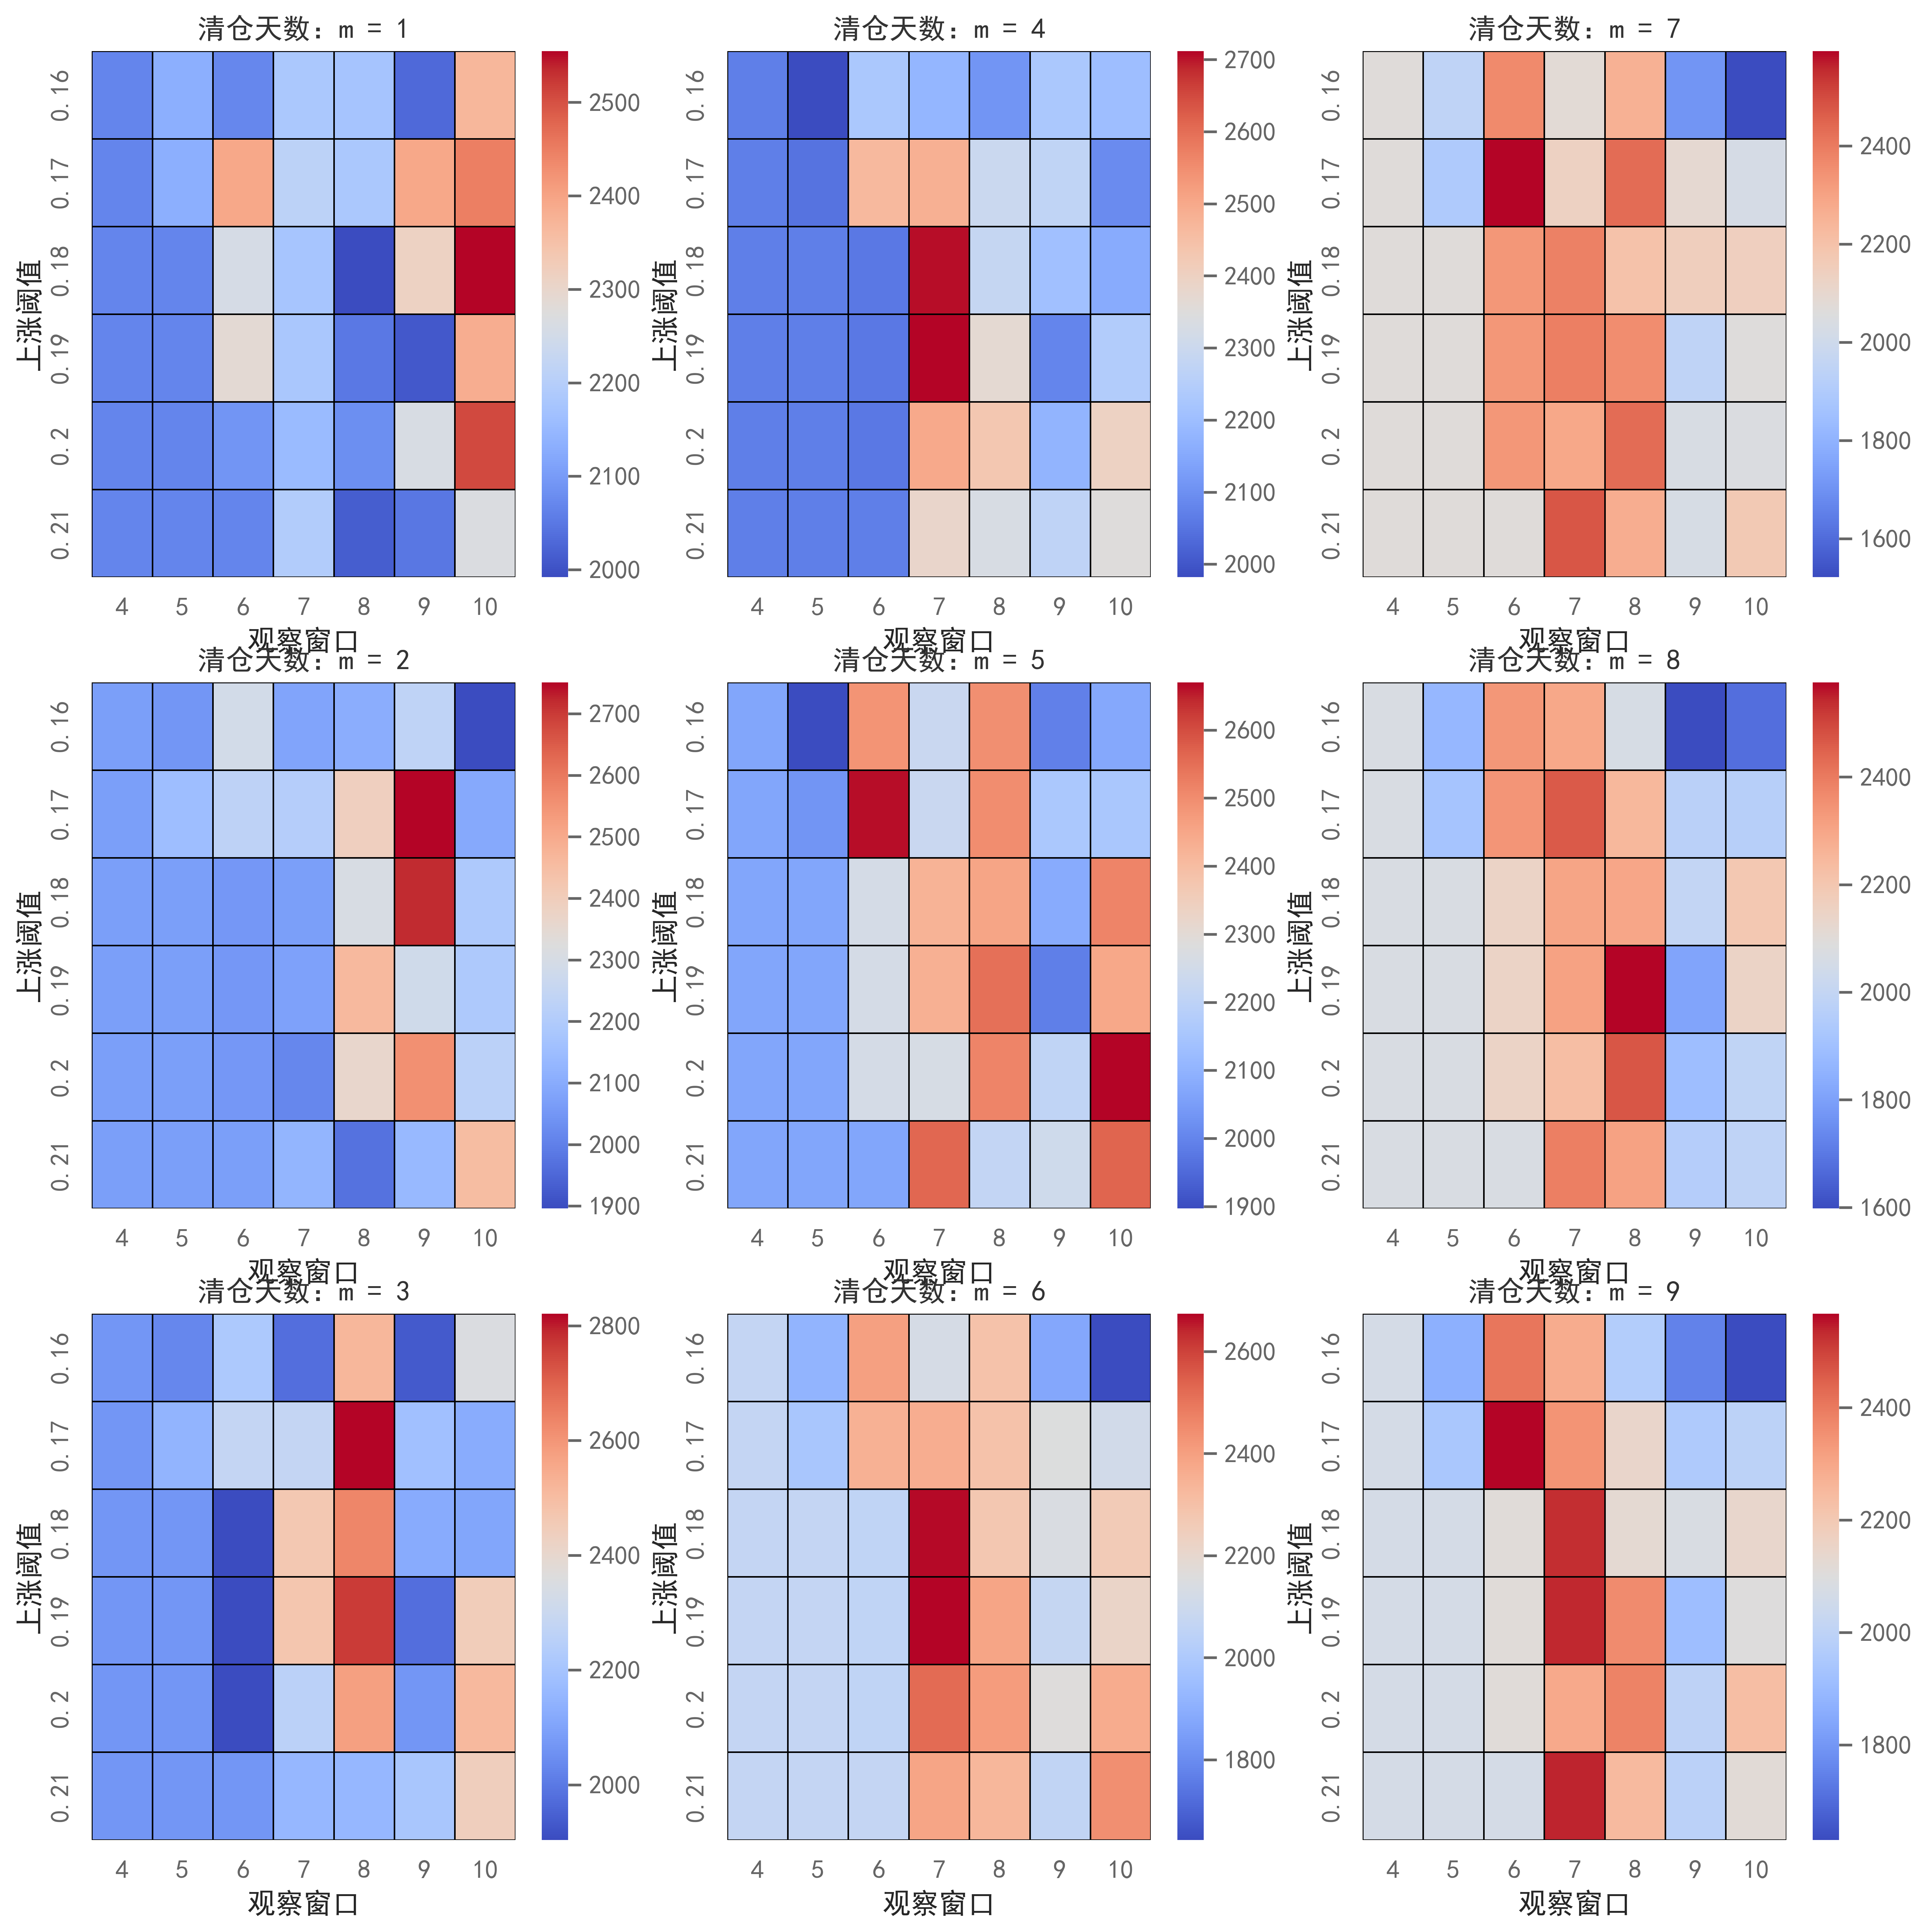

代码执行时间： 371 秒


In [6]:

#画出m = 1-9 时，不同上涨阈值和观察窗口的基于止损之后止盈后收益率热力图
# 观察窗口：n 
window_sizes = [4, 5, 6, 7, 8, 9, 10]
# 上涨阈值：s 
thresholds = [0.16, 0.17, 0.18, 0.19, 0.20, 0.21]
# 清仓天数：m 
stop_periods = list(range(1,10))
# 止损参数
stop_loss_param = (15, 8, -0.12)
pool_1.plot_stop_win_param_analysis(stop_loss_param, stop_periods, window_sizes, thresholds)

根据热力图的信息，选取止盈参数为“观察窗口天数：n = 8，回撤阈值：s = -0.12，清仓天数：m = 3”，  
观察窗口和止损参数一致，同时因为这四支ETF是精心挑选的，所以止盈的停仓天数小一些能尽量减少盈利损失

累计收益率：2821.8856135146925


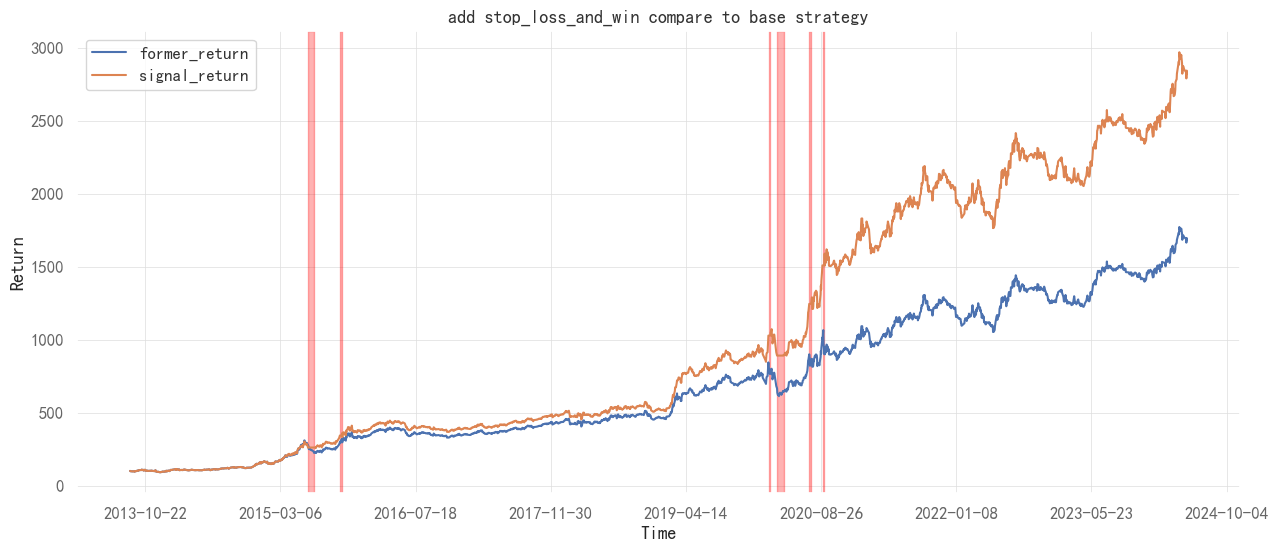

In [7]:
stop_loss_param = (15, 8, -0.12)    
stop_win_param = (3, 8, 0.17)
pool_1.get_result(stop_loss_param, stop_win_param)
pool_1.plot_result()

In [8]:
pool_1.result()

518880_return  513100_return  159915_return  510880_return  \
avg_return         0.006017       0.015808       0.007627       0.008080   
volatility         0.560591       0.826276       1.489351       0.841216   
sharpe             2.694454       4.797125       1.286458       2.411143   
max_drawdown      -0.986854      -0.996512      -1.000000      -0.999934   
win_rate           0.551564       0.664733       0.504438       0.597528   

              signal_return  base_strategy_return  
avg_return         0.001447              0.001216  
volatility         0.223413              0.234188  
sharpe             1.558785              1.283824  
max_drawdown      -0.194193             -0.276247  
win_rate           0.533038              0.529619

引入风险控制后，提升了整体收益率 ( 1683% --> 2821%)， 夏普指数 (1.28 --> 1.56)

我们接下来考虑22年之后的情况

还是选取相同的ETF池，截取22年至今的数据

累计收益率：148.40973103110633


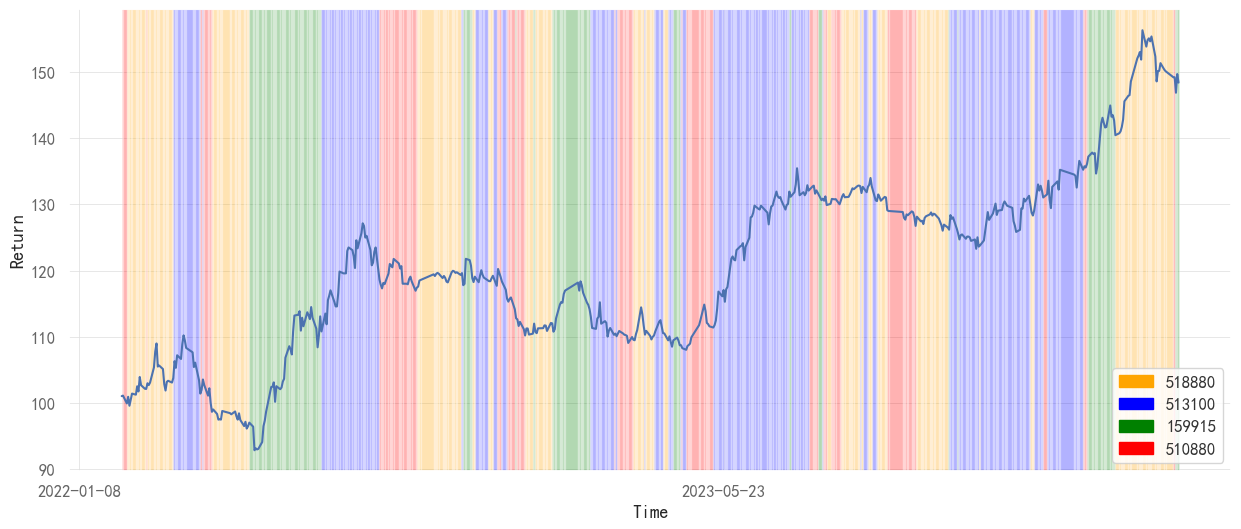

In [15]:
pool_1_period = EtfPool(['518880', '513100', '159915', '510880'])
pool_1_period.get_data("20220101","20490101")
pool_1_period.plot_return()

同上方的处理，再次进行止损止盈策略的参数分析

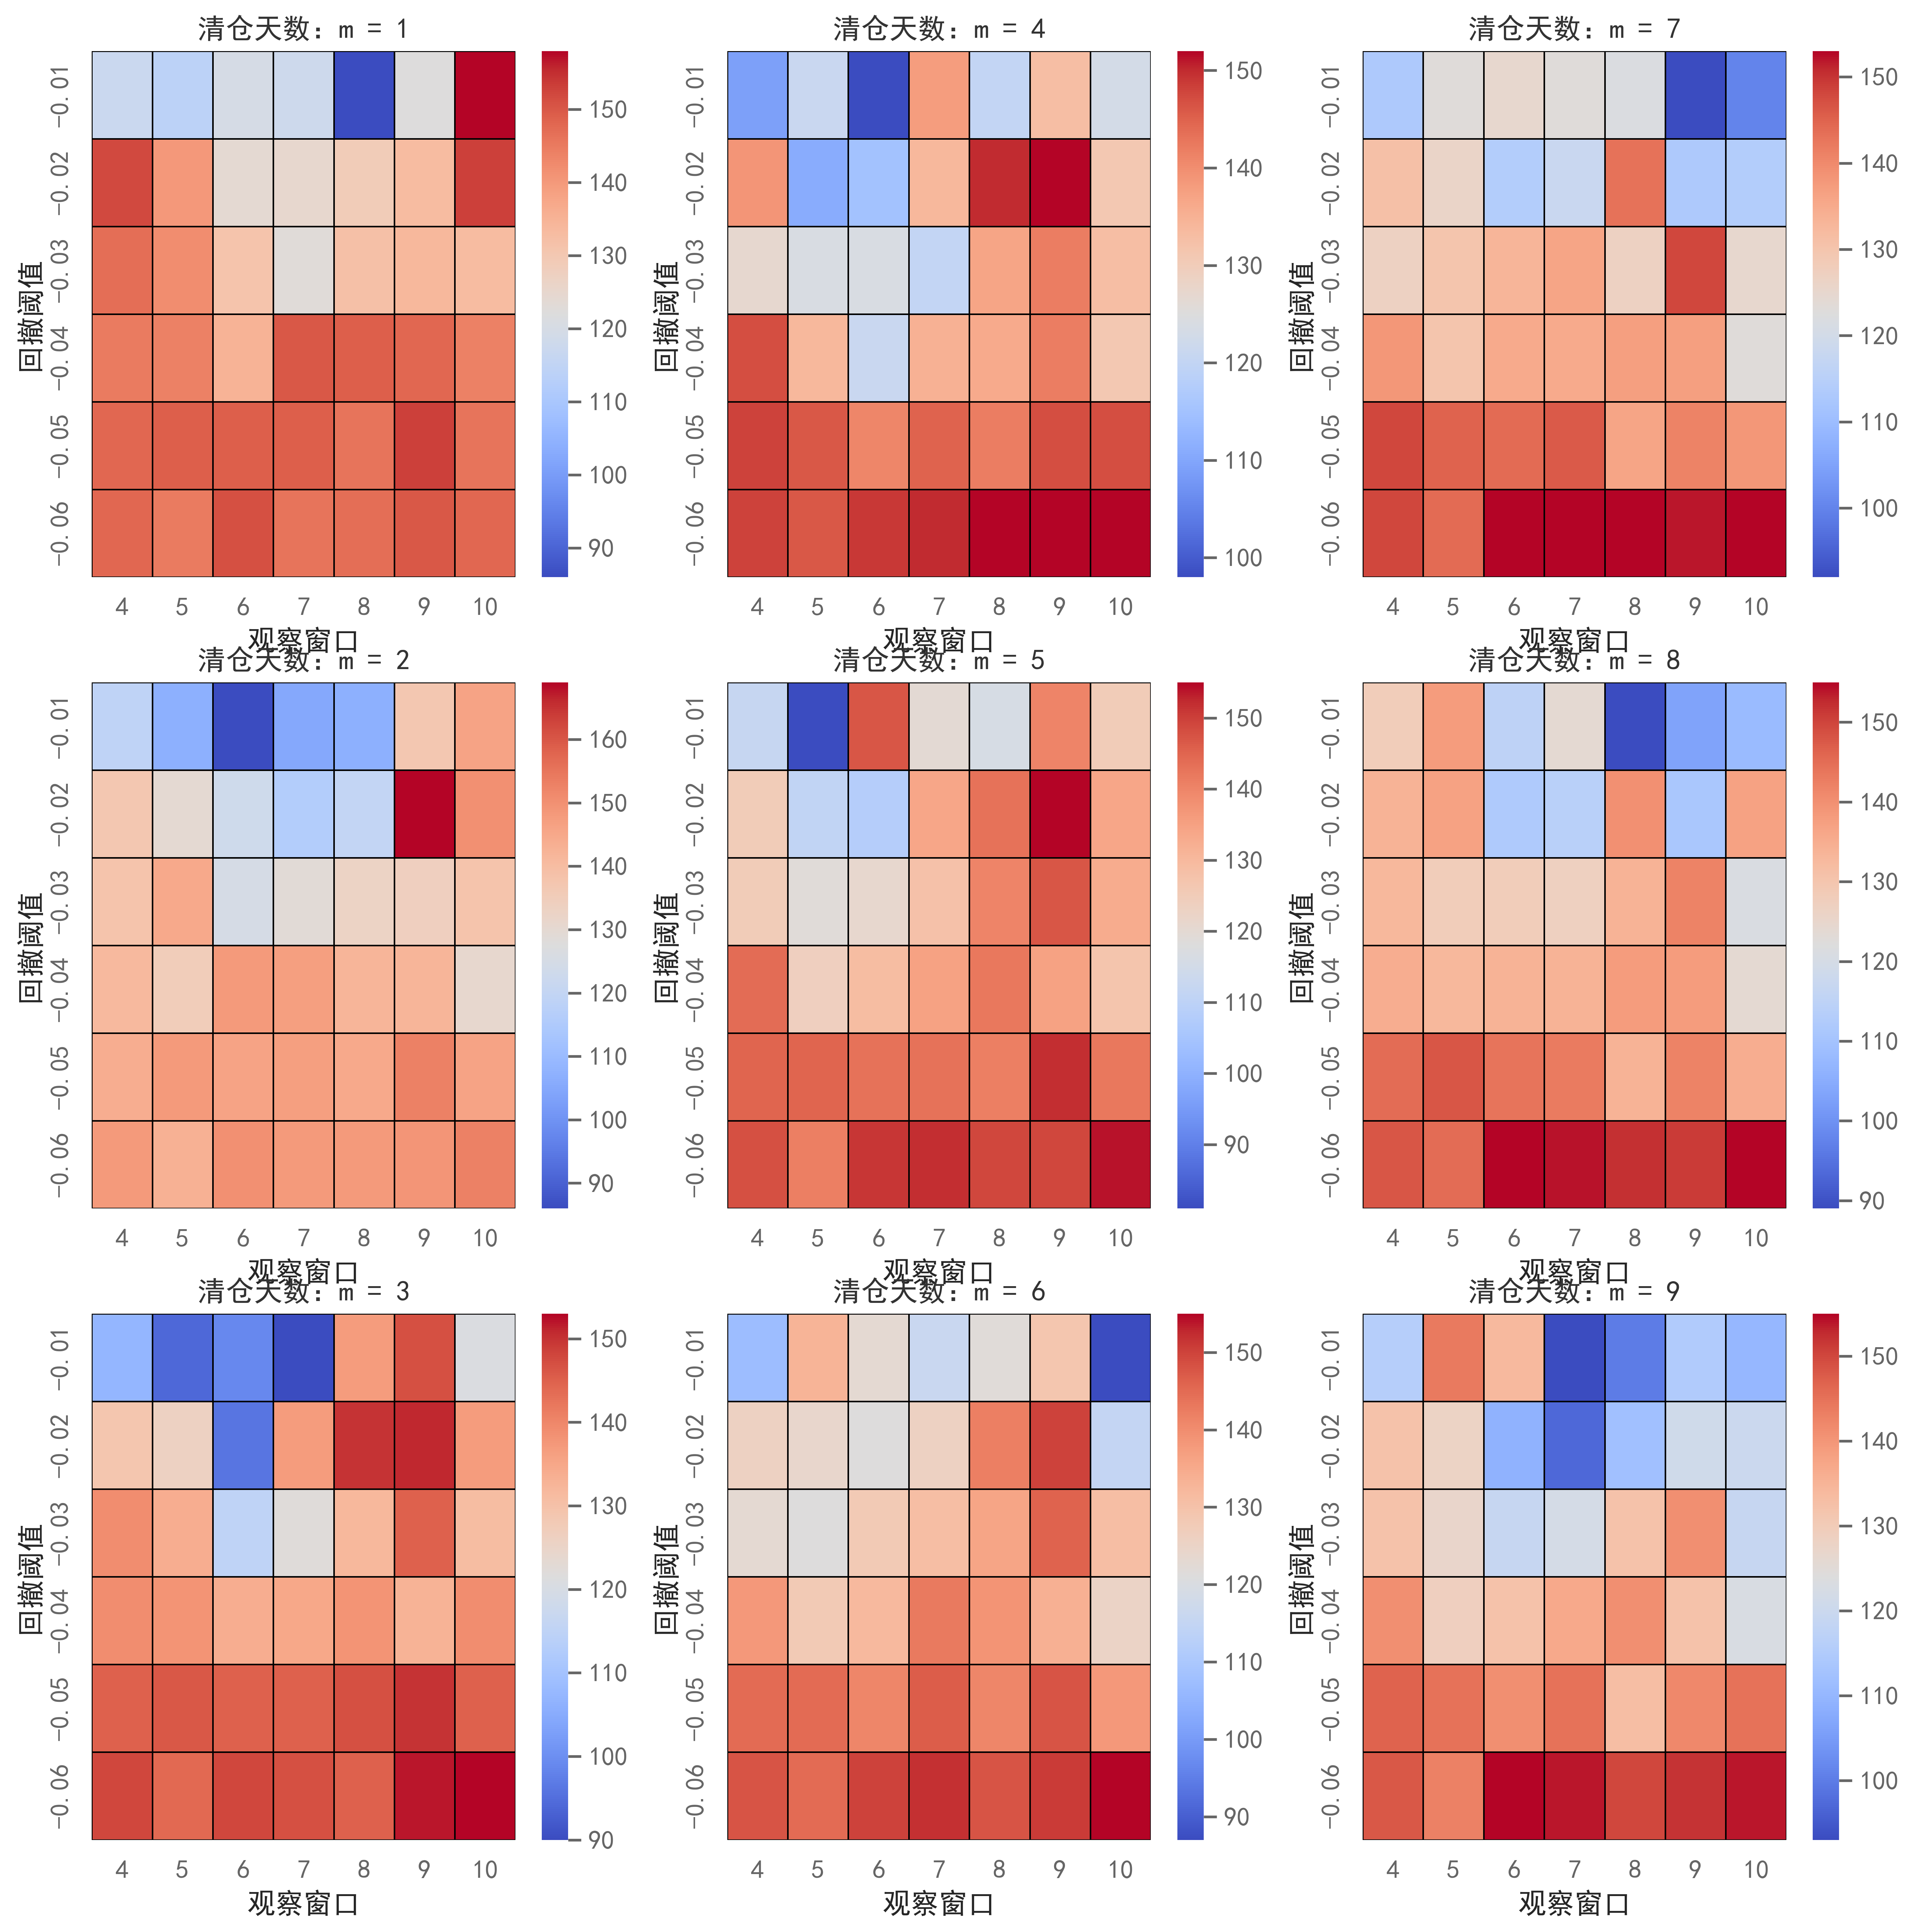

代码执行时间： 58 秒


In [16]:
#画出m = 1-9 时，不同回撤阈值和观察窗口的止损后收益率热力图
# 观察窗口：n 
window_sizes = [4, 5, 6, 7, 8, 9, 10]
# 回撤阈值：s 
thresholds = [-0.01, -0.02, -0.03, -0.04, -0.05, -0.06]
# 清仓天数：m 
stop_periods = list(range(1,10))
pool_1_period.plot_stop_loss_param_analysis(stop_periods, window_sizes, thresholds)

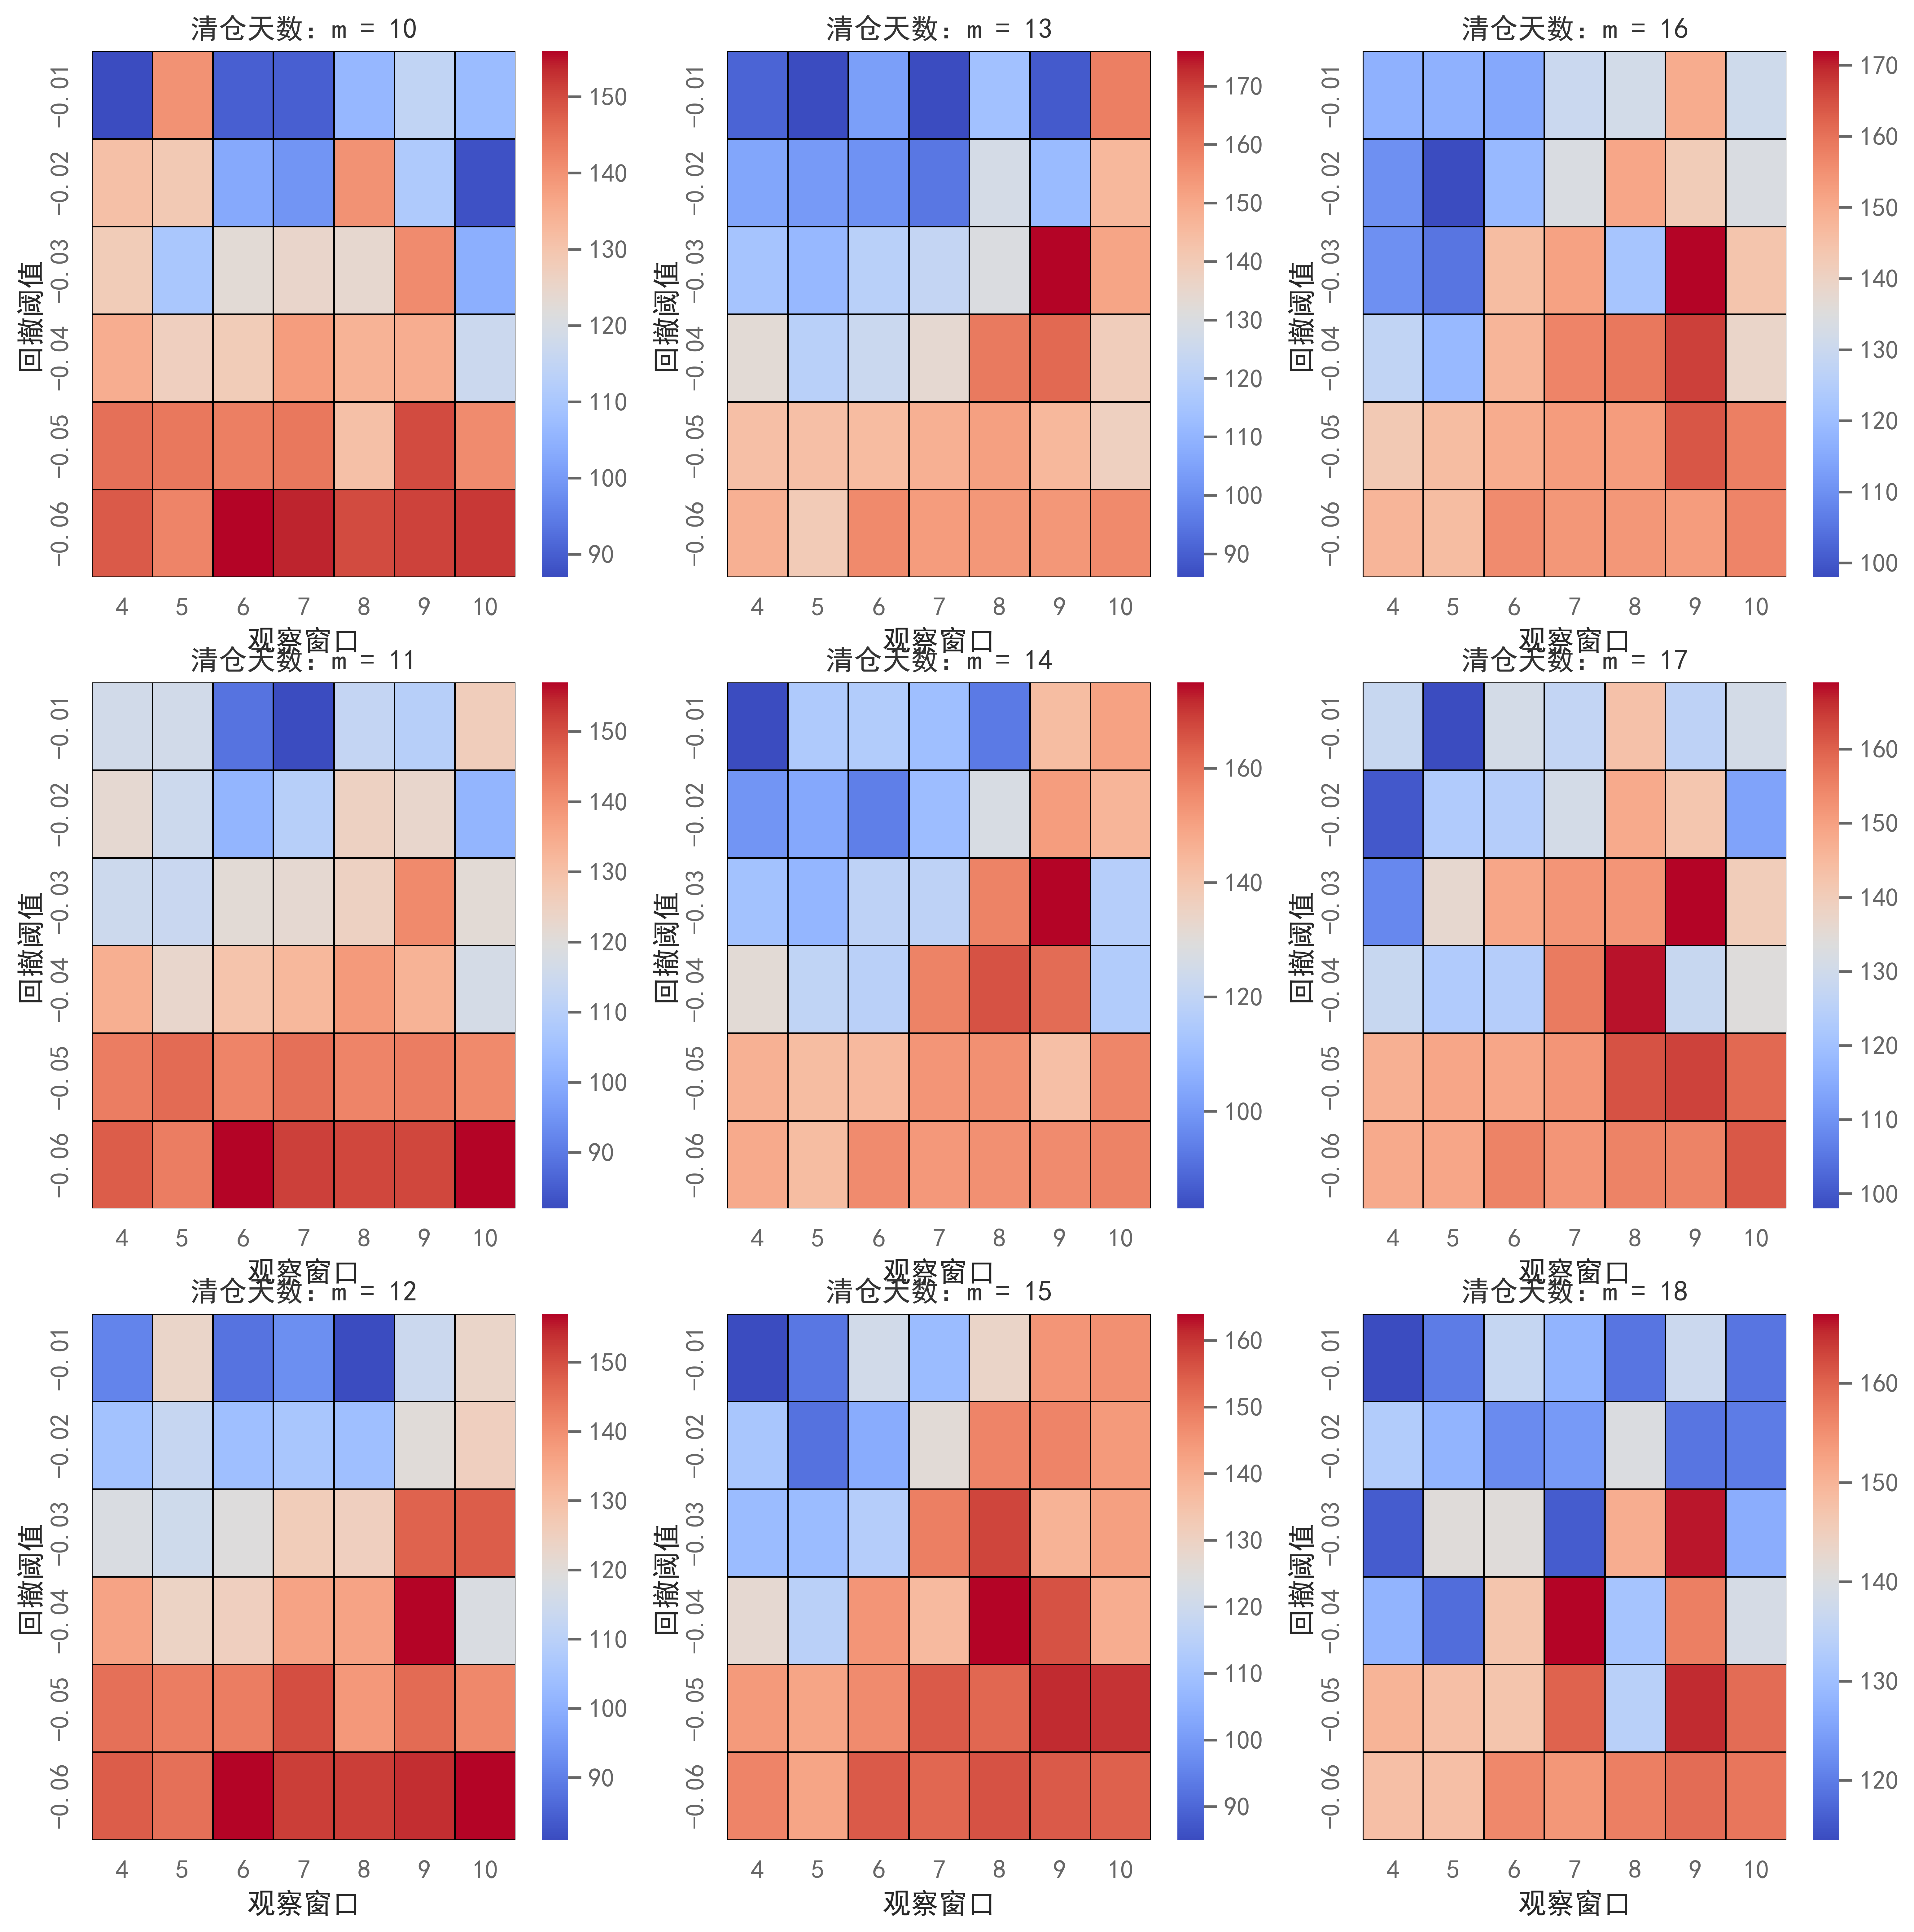

代码执行时间： 58 秒


In [17]:
#画出m = 10-18 时，不同回撤阈值和观察窗口的止损后收益率热力图
stop_periods = list(range(10,19))
pool_1_period.plot_stop_loss_param_analysis(stop_periods, window_sizes, thresholds)

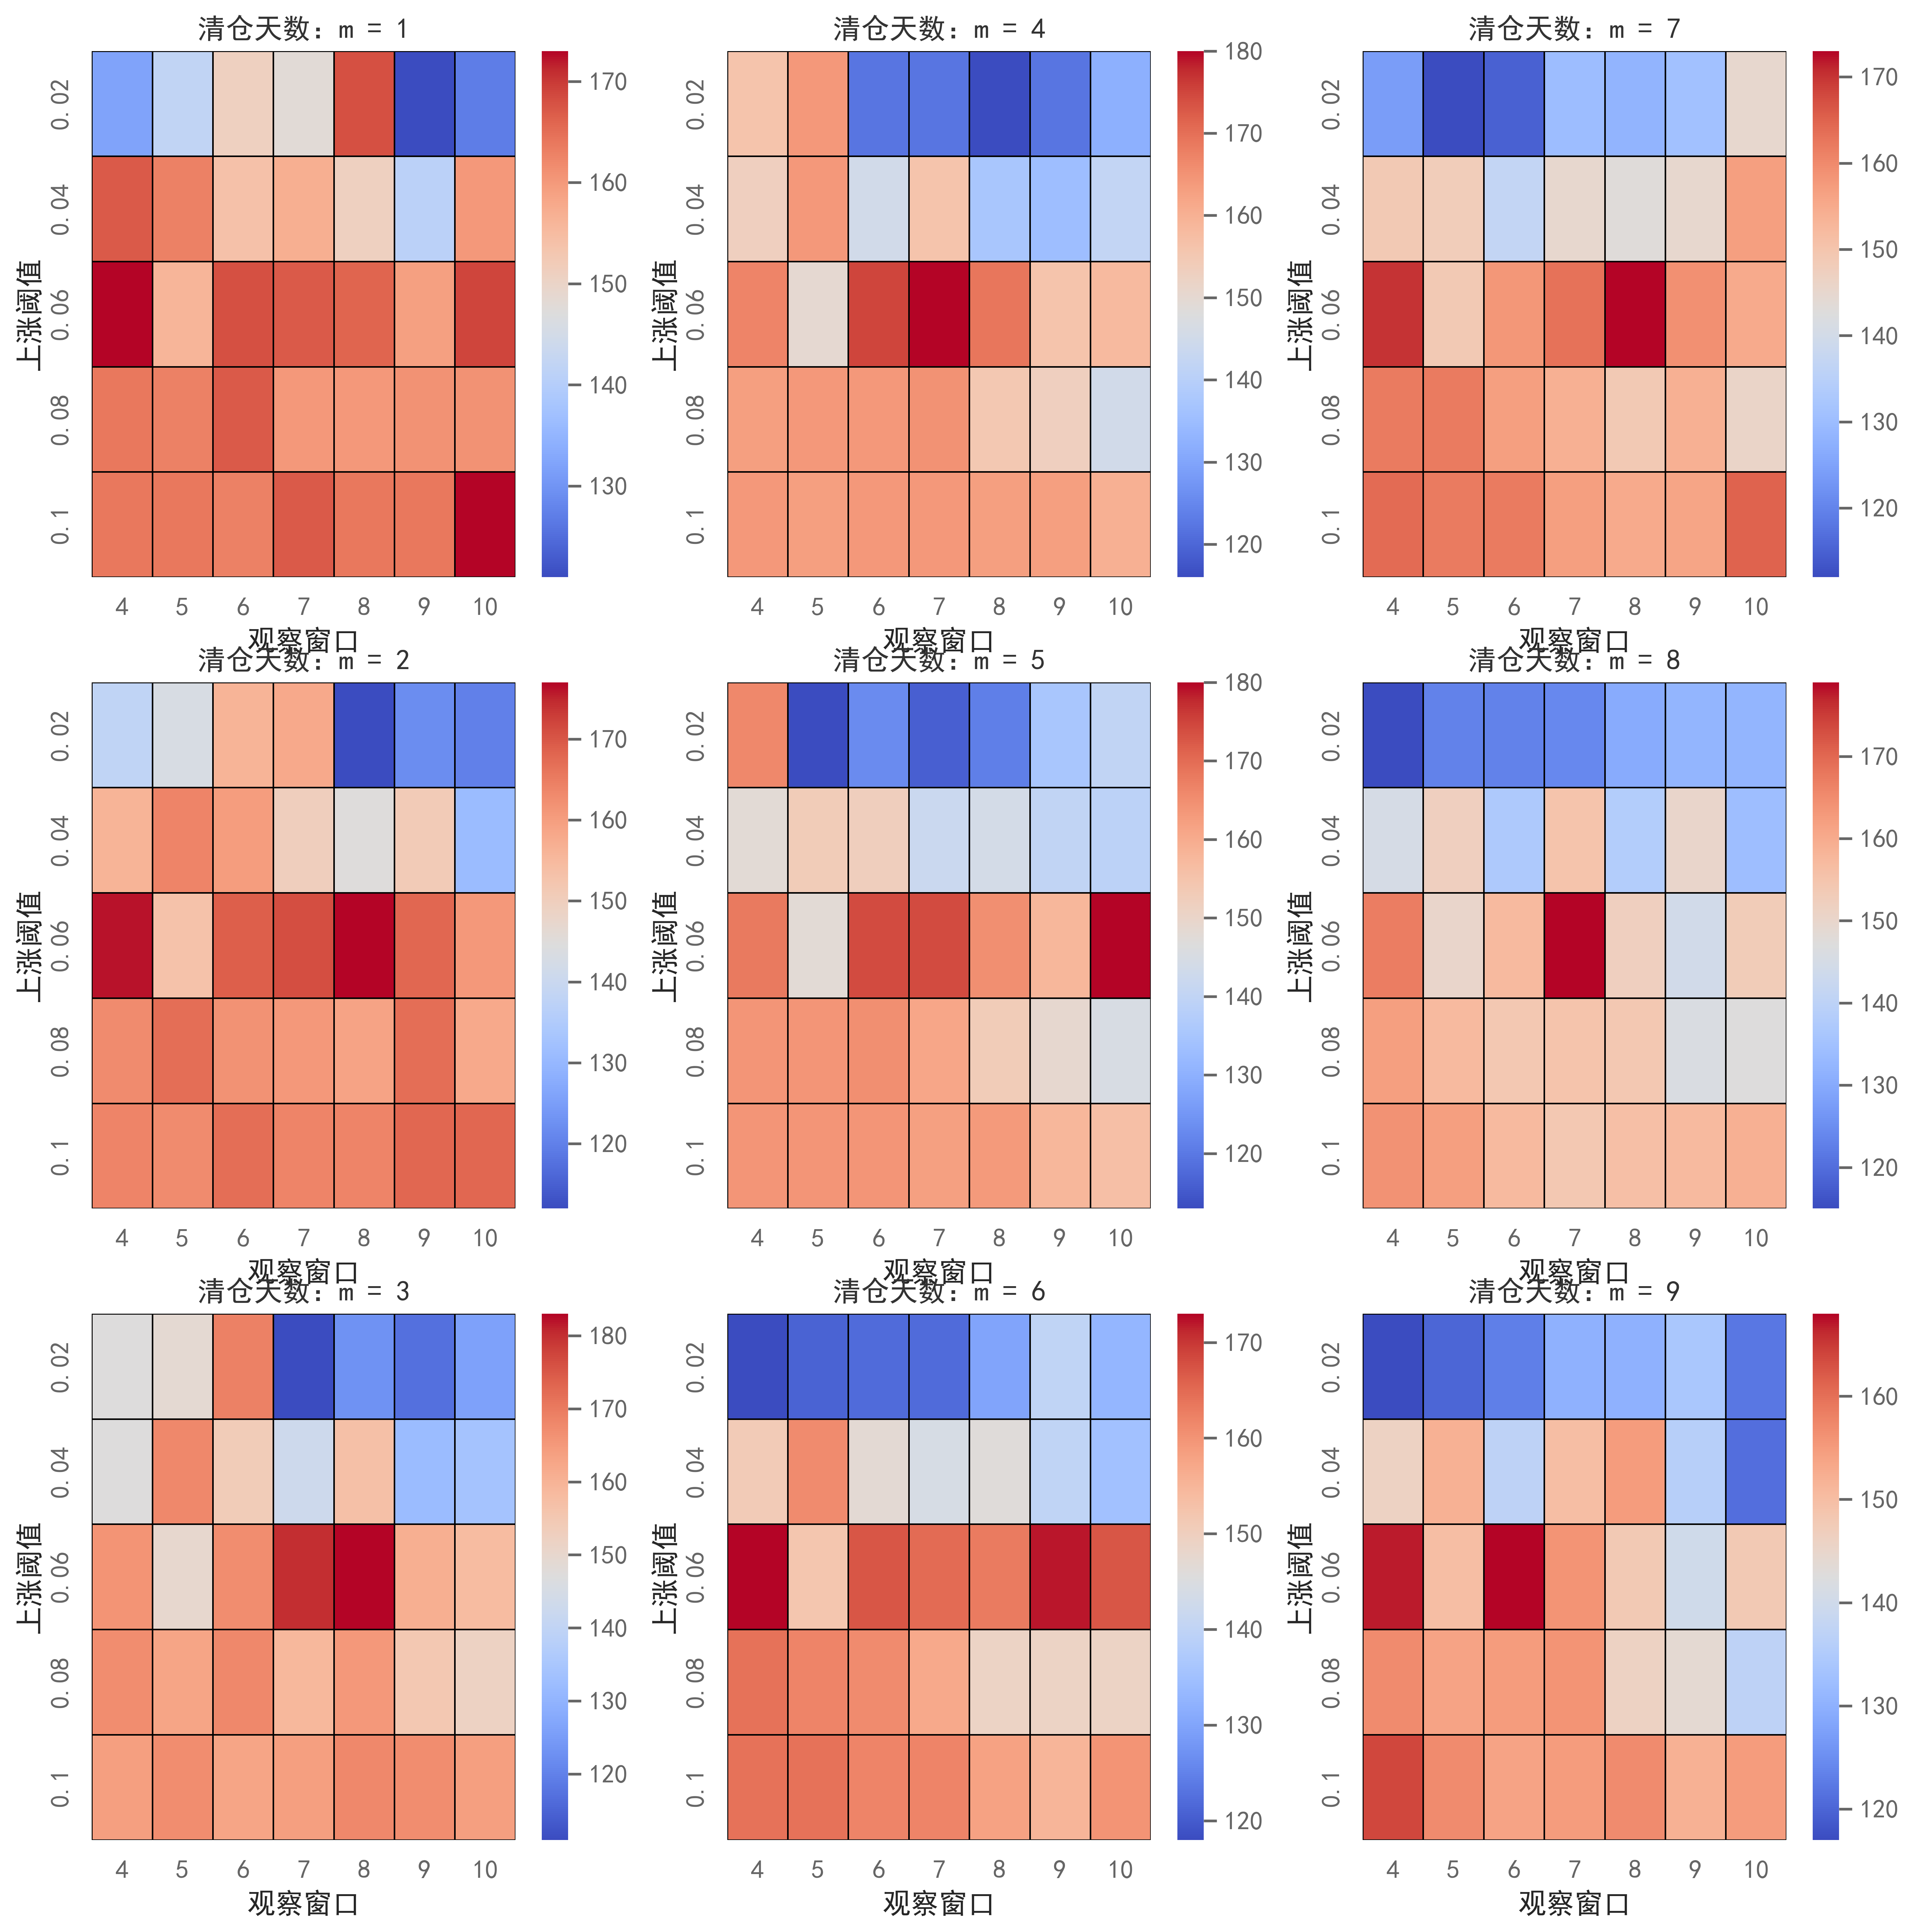

代码执行时间： 81 秒


In [18]:
#画出m = 1-9 时，不同上涨阈值和观察窗口的基于止损之后止盈后收益率热力图
# 观察窗口：n 
window_sizes = [4, 5, 6, 7, 8, 9, 10]
# 上涨阈值：s 
thresholds = [0.02, 0.04, 0.06, 0.08, 0.1]
# 清仓天数：m 
stop_periods = list(range(1,10))
# 止损参数
stop_loss_param = (15, 8, -0.04)

pool_1_period.plot_stop_win_param_analysis(stop_loss_param, stop_periods, window_sizes, thresholds)

类似上方的分析，选取止损参数为(15, 8, -0.04)，止盈参数为(3, 8, 0.06)

累计收益率：183.8167234747197


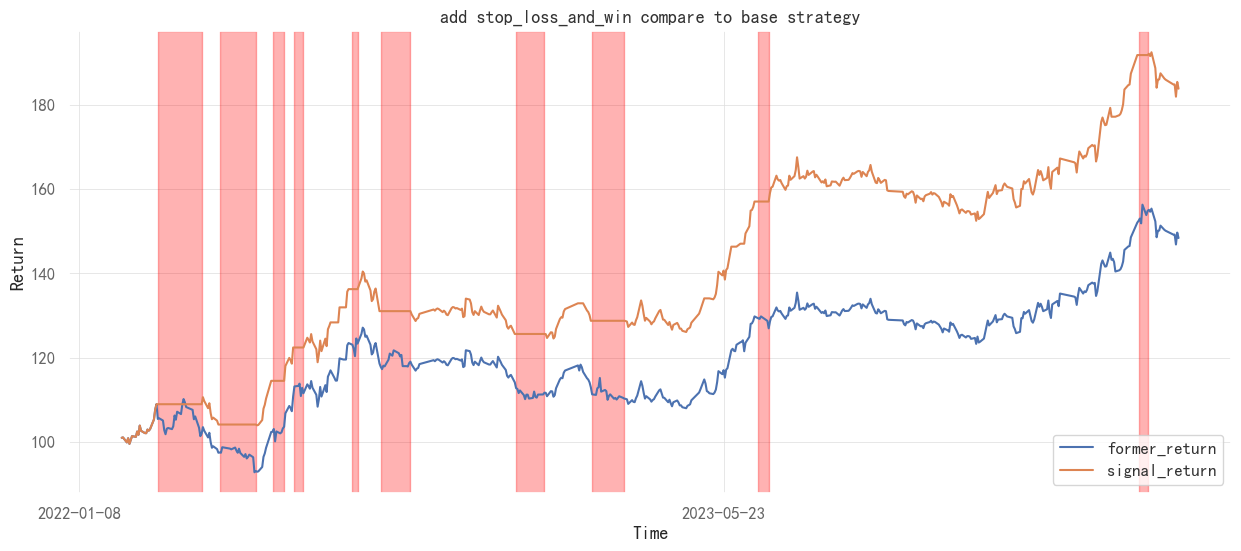

In [13]:
stop_loss_param = (15, 8, -0.04)
stop_win_param = (3, 8, 0.06)
pool_1_period.get_result(stop_loss_param, stop_win_param)
pool_1_period.plot_result()

In [14]:
pool_1_period.result()

518880_return  513100_return  159915_return  510880_return  \
avg_return         0.014698       0.011878      -0.016438       0.005964   
volatility         0.464162       0.901850       1.051423       0.431815   
sharpe             7.965200       3.319102      -3.932561       3.473901   
max_drawdown      -0.734544      -0.979652      -0.999992      -0.578023   
win_rate           0.705882       0.609174       0.334559       0.588235   

              signal_return  base_strategy_return  
avg_return         0.001589              0.000785  
volatility         0.150503              0.179240  
sharpe             1.913863              1.081030  
max_drawdown      -0.113037             -0.157429  
win_rate           0.538265              0.514981

引入风险控制后，提升了整体收益率 ( 148% --> 183%)， 夏普指数 (1.08 --> 1.91)